 Import Libraries

conda create -n bret-dual python==3.9
pip install torch transformers pandas scikit-learn


In [1]:
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup


Load and Prepare the Dataset

In [2]:
from transformers import BertTokenizer
from torch.utils.data import Dataset
import pandas as pd

# Load the dataset
df = pd.read_csv("/Users/chamodyaavishka/Desktop/EMAIL/product/datasetfinn.csv")

class EmailDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe['email'].values # Assuming 'email' is the column with the text you want to use
        self.labels = dataframe['label'].values  # Your binary labels
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]

        # Tokenizing the text
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,  # Adds '[CLS]' and '[SEP]'
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,  # Returns the attention mask
            return_tensors='pt',  # Returns PyTorch tensors
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Adjust max_len if necessary (depends on memory)
max_len = 256
batch_size = 8

# Initialize the dataset
email_dataset = EmailDataset(df, tokenizer, max_len=max_len)

# Example of using DataLoader (you might use it in a training loop)
from torch.utils.data import DataLoader

dataloader = DataLoader(email_dataset, batch_size=batch_size, shuffle=True)


Cell 3: Define the Model

In [3]:
class BertForDualOutput(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', num_labels_1=2, num_labels_2=2):
        super(BertForDualOutput, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        
        # Classification head for the first task (e.g., phishing or not)
        self.classifier_1 = nn.Linear(self.bert.config.hidden_size, num_labels_1)
        
        # Classification head for the second task (e.g., AI-generated or not)
        self.classifier_2 = nn.Linear(self.bert.config.hidden_size, num_labels_2)
        
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids, 
                            attention_mask=attention_mask, 
                            token_type_ids=token_type_ids)
        
        # Adjusted line here: Access the pooled output directly from the tuple
        pooled_output = outputs[1]
        
        pooled_output = self.dropout(pooled_output)
        
        # Get logits from each classifier
        logits_1 = self.classifier_1(pooled_output)
        logits_2 = self.classifier_2(pooled_output)

        return logits_1, logits_2


Cell 4: Training Function

In [4]:
import torch
from tqdm.notebook import tqdm

def train(model, dataloader, optimizer, criterion1, criterion2, epochs=1, device='cpu'):
    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc='Epoch {:1d}'.format(epoch+1), leave=False, disable=False)
        
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            optimizer.zero_grad()
            
            logits_1, logits_2 = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            
            # Assuming your dataset labels are organized as follows:
            # For the first task
            labels_1 = batch['labels_1']
            # For the second task
            labels_2 = batch['labels_2']
            
            loss1 = criterion1(logits_1, labels_1)
            loss2 = criterion2(logits_2, labels_2)
            
            # Combine losses
            total_loss = loss1 + loss2
            total_loss.backward()
            
            optimizer.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(total_loss.item()/len(batch))})
        
        torch.save(model.state_dict(), f'bert_dual_output_epoch_{epoch}.model')
        
        print(f'\nEpoch {epoch+1}, Training Loss: {total_loss:.2f}')


Cell 5: Initialize Model, Optimizer, and DataLoader

In [5]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn as nn
import torch

# Assuming the BertForDualOutput class and EmailDataset are already defined

# Initialize the model
model = BertForDualOutput()

# Specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Initialize the loss function for both tasks
# Assuming binary classification for both tasks. Adjust if necessary.
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()

# Initialize DataLoader
# Assuming email_dataset is already created from previous steps
dataloader = DataLoader(email_dataset, batch_size=8, shuffle=True)

# Move the criteria to the same device as the model
criterion1 = criterion1.to(device)
criterion2 = criterion2.to(device)


/Users/chamodyaavishka/anaconda3/envs/bert-dual/lib/python3.8/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Cell 6: Train the Model

Epoch 1/10:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 1: Loss = 0.3321, Accuracy = 0.8554


Epoch 2/10:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 2: Loss = 0.1433, Accuracy = 0.9539


Epoch 3/10:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 3: Loss = 0.0656, Accuracy = 0.9825


Epoch 4/10:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 4: Loss = 0.0578, Accuracy = 0.9788


Epoch 5/10:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 5: Loss = 0.0203, Accuracy = 0.9925


Epoch 6/10:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 6: Loss = 0.0165, Accuracy = 0.9938


Epoch 7/10:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 7: Loss = 0.0154, Accuracy = 0.9938


Epoch 8/10:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 8: Loss = 0.0169, Accuracy = 0.9938


Epoch 9/10:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 9: Loss = 0.0156, Accuracy = 0.9938


Epoch 10/10:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 10: Loss = 0.0157, Accuracy = 0.9938


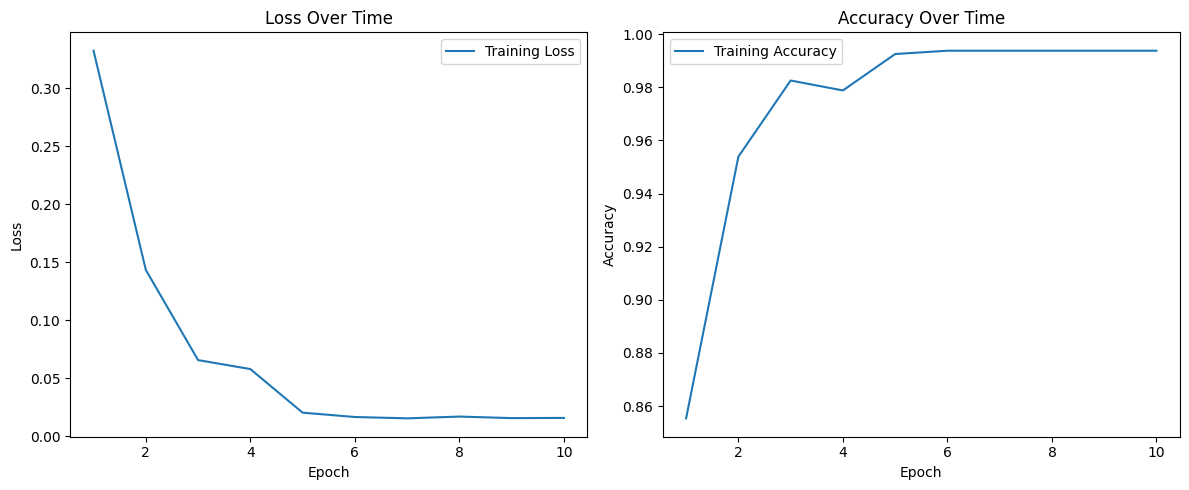

In [6]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def simple_accuracy(preds, labels):
    return (preds == labels).mean()

def train_and_plot(model, dataloader, optimizer, criterion1, criterion2, epochs=1, device='cpu'):
    model.train()
    
    # Lists to store per-epoch loss and accuracy
    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in range(epochs):
        total_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_1 = batch['labels'].to(device)  # Assuming single-label for simplification
            
            logits_1, logits_2 = model(input_ids, attention_mask=attention_mask)
            
            # Assuming the task of interest for accuracy calculation is the first one
            loss = criterion1(logits_1, labels_1)
            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            # Convert logits to predicted labels
            _, predicted_labels = torch.max(logits_1, dim=1)
            correct_predictions += (predicted_labels == labels_1).sum().item()
            total_predictions += labels_1.size(0)
        
        epoch_loss = total_loss / len(dataloader)
        epoch_accuracy = correct_predictions / total_predictions
        
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        
        print(f'Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}')
    
    # Plotting
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), epoch_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), epoch_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Assuming you've initialized your model, dataloader, and optimizer in previous cells
train_and_plot(model, dataloader, optimizer, criterion1, criterion2, epochs=15, device=device)


Cell 7: Save the Model

In [7]:
import os

# Define the base directory for saving and loading the model
base_path = "/Users/chamodyaavishka/Desktop/EMAIL/model7"

# Ensure the directory exists
if not os.path.exists(base_path):
    os.makedirs(base_path)

# Initialize the model
model = BertForDualOutput()

# Path for the model's state dictionary
model_filename = 'model_state_dict.pt'
model_path = os.path.join(base_path, model_filename)

# Assuming the model and tokenizer need to be saved
torch.save(model.state_dict(), model_path)
tokenizer.save_pretrained(base_path)

# Assuming now you need to load the model for evaluation or further processing
model.load_state_dict(torch.load(model_path))
model.eval()


BertForDualOutput(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise